## ID5030- Machine learning for Engineering and science applications
## Physics Informed Neural Networks
### Janmenjaya Panda ME20B087

## 1. PINN for an unsteady problem
### The advection equation in 1D is given by
$$ u_t + au_x = 0 $$
### a) Modify the Burgers equation code obtained from Raissi et. al to solve this equation with the same initial conditions and boundary conditions as Example 2.1 in the paper. Use the same ANN hyperparameters as in the paper.
### b) Compare the solutions you have obtained above with the exact solution for this equation. (Search online for exact solutions if you do not know the exact solution from previous classes!).

In [1]:
## Import required Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import math

In [2]:
tf.keras.backend.set_floatx("float64")

In [3]:
## Data Generation

# number of boundary and initial data points
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain, boundary and initial boundary
engine = qmc.LatinHypercube(d=1)

# temporal data points
t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1]) # for IC ; t = 0
t_d = np.append(temp, t_d, axis=0)

# spatial data points
x_d = engine.random(n=number_of_ic_points)
x_d = 2 * (x_d - 0.5)
temp1 = -1 * np.ones([number_of_bc1_points, 1]) # for BC1 ; x = -1
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

Text(0.5, 1.0, 'Data points (BCs & IC)')

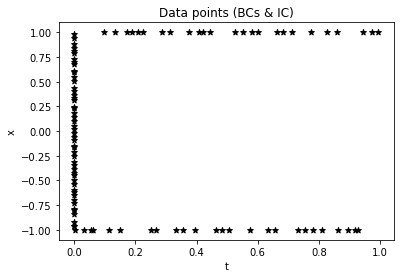

In [4]:
## View randomly sampled boundary and initial points
plt.scatter(t_d, x_d, marker="*", c="k")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

### Boundary Conditions
$$ u(0, x) = -sin(\pi x) $$
$$ u(t,-1) = u(t,1) = 0 $$

In [5]:
## Output values for data points (boundary and initial)
y_d = np.zeros(x_d.shape)

# For initial condition: IC = -sin(pi*x)
y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

# All boundary conditions are set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0

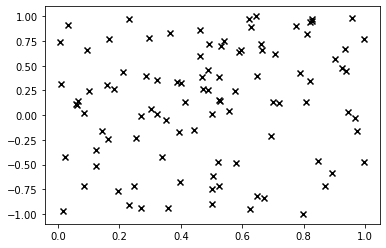

In [6]:
# Number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)

# Set x values between -1. and +1.
data[:, 1] = 2*(data[:, 1]-0.5)

# Change names
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

plt.scatter(t_c[0:100] , x_c[0:100] , marker="x", c="k")

In [7]:
# convert all data and collocation points to tf.Tensor
x_d, t_d, y_d, x_c, t_c = map(tf.convert_to_tensor, [x_d, t_d, y_d, x_c, t_c])

In [8]:
## Model design
neuron_per_layer = 20

# activation function for all hidden layers
actfn = "tanh"

# input layer
input_layer = tf.keras.layers.Input(shape=(2,))

# hidden layer: also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)
hidden6 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden5)
hidden7 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden6)
hidden8 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden7)

# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden8)

model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

In [9]:
# Function u(t, x) just makes working with model easier and the whole code looks more like its mathematical backend
@tf.function
def u(t, x):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model(tf.concat([t, x], axis=1)) # note the axis ; `column`
    return u

In [10]:
# The physics informed loss function
# This loss function is used for collocation points
@tf.function
def f(t, x):
    u0 = u(t, x)
    u_t = tf.gradients(u0, t)[0]
    u_x = tf.gradients(u0, x)[0]
    F = u_t + (0.01/np.pi)*u_x
    return tf.reduce_mean(tf.square(F))

In [11]:
# MSE loss function
# This loss function is used for data points
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

In [12]:
"""
BENCHMARK on Google Colab GPU

learning_rate = 5e-4
epochs = 2000
training time ~ 85.60 s
final loss = 0.006
"""

epochs = 1000
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
start = time.time()

# training loop
# A while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_ = u(t_d, x_d)
        
        # physics-informed loss for collocation points
        L1 = f(t_c, x_c)
        
        # MSE loss for data points: boundary loss
        L2 = mse(y_d, y_)
        loss = L1 + L2

    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"epoch - {epoch:4} /{epochs} : {loss.numpy():.3f}")
    
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

epoch -    0 /1000 : 0.211
epoch -   10 /1000 : 0.196
epoch -   20 /1000 : 0.190
epoch -   30 /1000 : 0.182
epoch -   40 /1000 : 0.166
epoch -   50 /1000 : 0.136
epoch -   60 /1000 : 0.096
epoch -   70 /1000 : 0.059
epoch -   80 /1000 : 0.037
epoch -   90 /1000 : 0.025
epoch -  100 /1000 : 0.016
epoch -  110 /1000 : 0.011
epoch -  120 /1000 : 0.008
epoch -  130 /1000 : 0.006
epoch -  140 /1000 : 0.005
epoch -  150 /1000 : 0.004
epoch -  160 /1000 : 0.003
epoch -  170 /1000 : 0.003
epoch -  180 /1000 : 0.003
epoch -  190 /1000 : 0.002
epoch -  200 /1000 : 0.002
epoch -  210 /1000 : 0.002
epoch -  220 /1000 : 0.002
epoch -  230 /1000 : 0.002
epoch -  240 /1000 : 0.002
epoch -  250 /1000 : 0.001
epoch -  260 /1000 : 0.001
epoch -  270 /1000 : 0.001
epoch -  280 /1000 : 0.001
epoch -  290 /1000 : 0.001
epoch -  300 /1000 : 0.001
epoch -  310 /1000 : 0.001
epoch -  320 /1000 : 0.001
epoch -  330 /1000 : 0.001
epoch -  340 /1000 : 0.001
epoch -  350 /1000 : 0.001
epoch -  360 /1000 : 0.001
e

Text(0.5, 0, 'epoch')

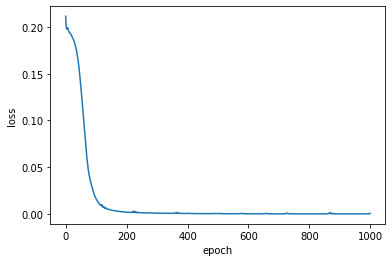

In [13]:
## Plot loss vs epoch
plt.plot(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

### Predicted Solution

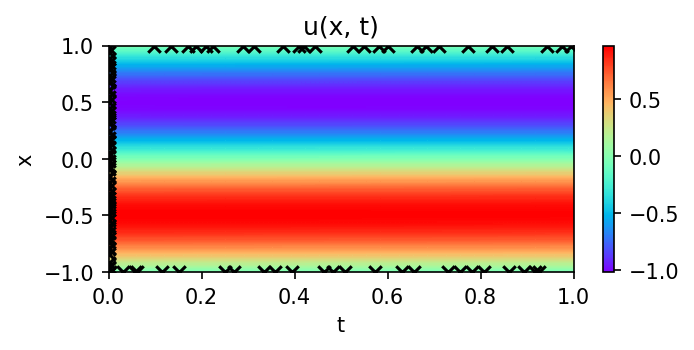

In [14]:
## Plot 
n, m = 100, 200

X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)

X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)

X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=150)

S = u(T, X)
S = S.numpy().reshape(n, m)

plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

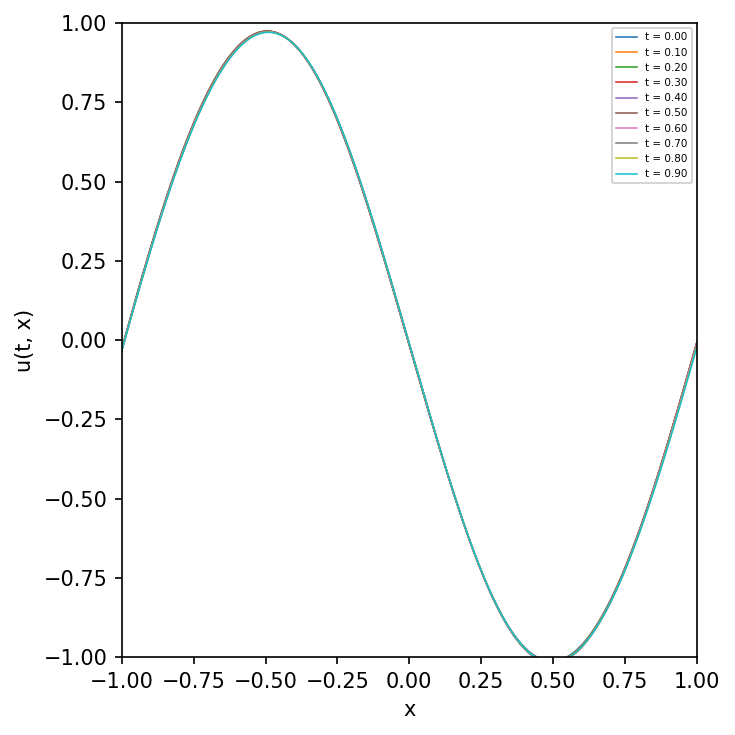

In [15]:
plt.figure(figsize=(5, 5), dpi=150)

# input shape
n_temporal, n_spatial = 10, 2000

# combine (x, t) as a vector
v = np.zeros([n_spatial, 2]) # v[:, 0] = t, v[:, 1] = x
v[:, 1] = np.linspace(-1, +1, n_spatial)

# change t
for i in range(n_temporal):
    v[:, 0] = i/n_temporal
    plt.plot(v[:, 1], model.predict(v), label=f"t = {i/n_temporal:.2f}", lw=0.75)

plt.legend(loc="upper right", fontsize=5)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.ylabel(f"u(t, x)")
plt.xlabel(f"x")
plt.tight_layout()
plt.savefig("u-constant-time.png")
plt.show()

## Analytical Solution:

In [16]:
def U_analytical(X,T):
  a = 0.01/np.pi
  X = np.array(X)
  T = np.array(T)
  # U_ana = np.sin(np.pi*X)*(X + a*T)    # taking Ψo = -math.sin(math.pi*x)
  U_ana = -np.sin(np.pi*(X - a*T))  
  return U_ana

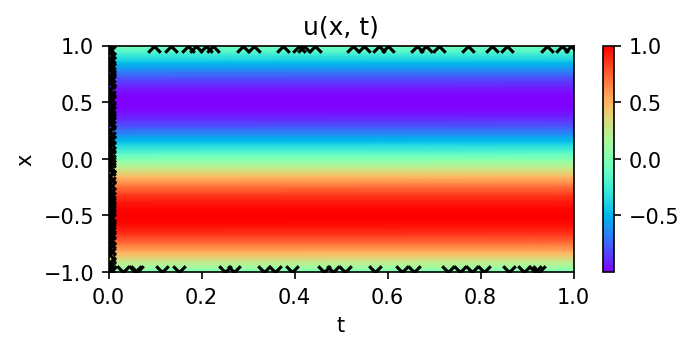

In [17]:
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)

X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
plt.figure(figsize=(5, 2), dpi=150)

S = U_analytical(X,T)
S = S.reshape(n, m)

plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

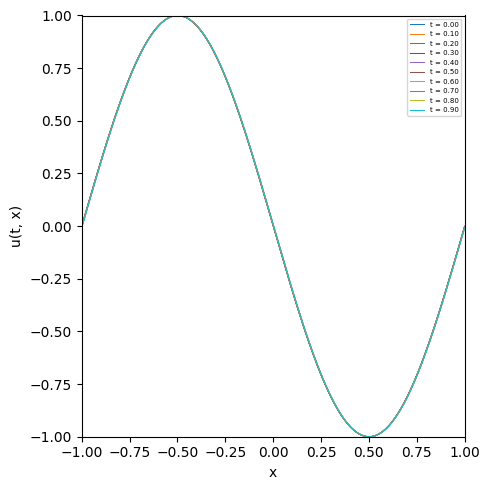

In [18]:
# Make a function `u(t, x)` to use model easier
u = lambda t, x: U_analytical(x,t)
plt.figure(figsize=(5, 5), dpi=100)

# input shape
n_temporal, n_spatial = 10, 2000

# combine (x, t) as a vector
v = np.zeros([n_spatial, 2]) # v[:, 0] = t, v[:, 1] = x
v[:, 1] = np.linspace(-1, +1, n_spatial)

# change t
for i in range(n_temporal):
    v[:, 0] = i/n_temporal
    plt.plot(v[:, 1], U_analytical(v[:,1],v[:,0]), label=f"t = {i/n_temporal:.2f}", lw=0.75)

plt.legend(loc="upper right", fontsize=5)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.ylabel(f"u(t, x)")
plt.xlabel(f"x")
plt.tight_layout()
plt.show()

### Comparison btwn analytical \& PINN solutions

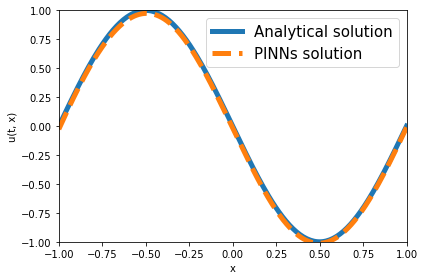

In [19]:
## Analytical vs PINN
n, m = 100, 200
X = np.linspace(-1, +1, m).reshape((-1,1))
T = np.zeros((m,1))

S = U_analytical(X,T)

plt.plot(X , S  , label = "Analytical solution" , lw = 5)
n_temporal, n_spatial = 10, 2000

# combine (x, t) as a vector
v = np.zeros([n_spatial, 2]) # v[:, 0] = t, v[:, 1] = x
v[:, 1] = np.linspace(-1, +1, n_spatial)
v[:, 0] = 0

plt.plot(v[:, 1], model.predict(v), label="PINNs solution", lw=5 , linestyle='--')
plt.legend(loc="upper right", fontsize=15)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.ylabel(f"u(t, x)")
plt.xlabel(f"x")
plt.tight_layout()
plt.show()

### It can be seen that exact and solution predicted by PINNs are almost same.

## 2. Effect of boundary conditions imposition –
### Consider Problem 5 (Section 4.2.1) in the Lagaris et. al. paper.
### a) Replicate the results of this using the Lagaris approach for boundary conditions. Use a neural network with one hidden layer and 10 neurons as in the paper.

In [20]:
## Model design

# input layer
input_layer = tf.keras.layers.Input(shape=(2,))

# hidden layer also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(10, activation="tanh")(input_layer)

# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden0)

model_lagg = tf.keras.Model(input_layer, output_layer)
model_lagg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 10)                30        
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [21]:
# u(t, x) just makes working with model easier and the whole code looks more like its mathematical backend
@tf.function
def u(x, y):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model_lagg(tf.concat([x, y], axis=1)) # note the axis ; `column`
    return u

# This loss function is used for collocation points
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_y = tf.gradients(u0, y)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x,x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    u_yx = tf.gradients(u_y,x)[0]
    
    e = tf.exp( tf.cast(tf.constant(1.0), tf.float64))
    e_ = tf.exp(tf.cast(tf.constant(-1.0), tf.float64))

    # A = (1 - x)*y**3 + x*(1 + y**3)*e**(-1) + (1 - y)*x*(e**(-x) - e**(-1)) + y*((1 + x)*e**(-x) - (1 - x - 2*x*e**(-1)))
 
    A = (1 - x)*tf.math.pow(y, 3) + x*(1 + tf.math.pow(y, 3))*e_ + (1 - y)*x*(tf.exp(-x) - e_) + y*((1 + x)*tf.exp(-x) - (1 - x - 2*x*e_))
    N = u_xx + u_yy + 2*u_yx - tf.exp(-x)*(x - 2 + tf.math.pow(y, 3) + 6*y)
    F = A + x*(1 - x)*y*(1 - y)*N

    return tf.reduce_mean(tf.square(F))

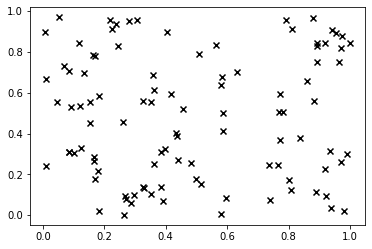

In [22]:
### Creating Data

# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)

# change names
x_c = np.expand_dims(data[:, 0], axis=1)
y_c = np.expand_dims(data[:, 1], axis=1)

plt.scatter(x_c[0:100] , y_c[0:100] , marker="x", c="k")

In [23]:
# convert all data and collocation points to tf.Tensor
x_c, y_c = map(tf.convert_to_tensor, [ x_c, y_c])

In [24]:
"""
BENCHMARK on Google Colab GPU

learning_rate = 5e-4
epochs = 2000
training time ~ 85.60 s
final loss = 0.006
"""

epochs = 25000
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:

        # physics-informed loss for collocation points
        L1 = f(x_c, y_c)

        loss = L1 
    # compute gradients
    g = tape.gradient(loss, model_lagg.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"epoch - {epoch:4} /{epochs} : {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model_lagg.trainable_weights))

epoch -    0 /25000 : 0.753
epoch -   10 /25000 : 0.752
epoch -   20 /25000 : 0.750
epoch -   30 /25000 : 0.749
epoch -   40 /25000 : 0.747
epoch -   50 /25000 : 0.745
epoch -   60 /25000 : 0.743
epoch -   70 /25000 : 0.742
epoch -   80 /25000 : 0.740
epoch -   90 /25000 : 0.738
epoch -  100 /25000 : 0.736
epoch -  110 /25000 : 0.734
epoch -  120 /25000 : 0.732
epoch -  130 /25000 : 0.730
epoch -  140 /25000 : 0.727
epoch -  150 /25000 : 0.725
epoch -  160 /25000 : 0.723
epoch -  170 /25000 : 0.720
epoch -  180 /25000 : 0.718
epoch -  190 /25000 : 0.715
epoch -  200 /25000 : 0.713
epoch -  210 /25000 : 0.710
epoch -  220 /25000 : 0.707
epoch -  230 /25000 : 0.704
epoch -  240 /25000 : 0.701
epoch -  250 /25000 : 0.698
epoch -  260 /25000 : 0.695
epoch -  270 /25000 : 0.692
epoch -  280 /25000 : 0.689
epoch -  290 /25000 : 0.686
epoch -  300 /25000 : 0.682
epoch -  310 /25000 : 0.679
epoch -  320 /25000 : 0.675
epoch -  330 /25000 : 0.672
epoch -  340 /25000 : 0.668
epoch -  350 /25000 

epoch - 2930 /25000 : 0.311
epoch - 2940 /25000 : 0.310
epoch - 2950 /25000 : 0.309
epoch - 2960 /25000 : 0.308
epoch - 2970 /25000 : 0.307
epoch - 2980 /25000 : 0.306
epoch - 2990 /25000 : 0.306
epoch - 3000 /25000 : 0.305
epoch - 3010 /25000 : 0.304
epoch - 3020 /25000 : 0.303
epoch - 3030 /25000 : 0.302
epoch - 3040 /25000 : 0.302
epoch - 3050 /25000 : 0.301
epoch - 3060 /25000 : 0.300
epoch - 3070 /25000 : 0.299
epoch - 3080 /25000 : 0.299
epoch - 3090 /25000 : 0.298
epoch - 3100 /25000 : 0.297
epoch - 3110 /25000 : 0.297
epoch - 3120 /25000 : 0.296
epoch - 3130 /25000 : 0.295
epoch - 3140 /25000 : 0.294
epoch - 3150 /25000 : 0.294
epoch - 3160 /25000 : 0.293
epoch - 3170 /25000 : 0.292
epoch - 3180 /25000 : 0.292
epoch - 3190 /25000 : 0.291
epoch - 3200 /25000 : 0.290
epoch - 3210 /25000 : 0.290
epoch - 3220 /25000 : 0.289
epoch - 3230 /25000 : 0.288
epoch - 3240 /25000 : 0.288
epoch - 3250 /25000 : 0.287
epoch - 3260 /25000 : 0.287
epoch - 3270 /25000 : 0.286
epoch - 3280 /25000 

epoch - 5860 /25000 : 0.180
epoch - 5870 /25000 : 0.179
epoch - 5880 /25000 : 0.179
epoch - 5890 /25000 : 0.179
epoch - 5900 /25000 : 0.179
epoch - 5910 /25000 : 0.178
epoch - 5920 /25000 : 0.178
epoch - 5930 /25000 : 0.178
epoch - 5940 /25000 : 0.178
epoch - 5950 /25000 : 0.178
epoch - 5960 /25000 : 0.177
epoch - 5970 /25000 : 0.177
epoch - 5980 /25000 : 0.177
epoch - 5990 /25000 : 0.177
epoch - 6000 /25000 : 0.176
epoch - 6010 /25000 : 0.176
epoch - 6020 /25000 : 0.176
epoch - 6030 /25000 : 0.176
epoch - 6040 /25000 : 0.176
epoch - 6050 /25000 : 0.175
epoch - 6060 /25000 : 0.175
epoch - 6070 /25000 : 0.175
epoch - 6080 /25000 : 0.175
epoch - 6090 /25000 : 0.174
epoch - 6100 /25000 : 0.174
epoch - 6110 /25000 : 0.174
epoch - 6120 /25000 : 0.174
epoch - 6130 /25000 : 0.174
epoch - 6140 /25000 : 0.173
epoch - 6150 /25000 : 0.173
epoch - 6160 /25000 : 0.173
epoch - 6170 /25000 : 0.173
epoch - 6180 /25000 : 0.173
epoch - 6190 /25000 : 0.172
epoch - 6200 /25000 : 0.172
epoch - 6210 /25000 

epoch - 8790 /25000 : 0.123
epoch - 8800 /25000 : 0.123
epoch - 8810 /25000 : 0.123
epoch - 8820 /25000 : 0.123
epoch - 8830 /25000 : 0.123
epoch - 8840 /25000 : 0.122
epoch - 8850 /25000 : 0.122
epoch - 8860 /25000 : 0.122
epoch - 8870 /25000 : 0.122
epoch - 8880 /25000 : 0.122
epoch - 8890 /25000 : 0.122
epoch - 8900 /25000 : 0.121
epoch - 8910 /25000 : 0.121
epoch - 8920 /25000 : 0.121
epoch - 8930 /25000 : 0.121
epoch - 8940 /25000 : 0.121
epoch - 8950 /25000 : 0.121
epoch - 8960 /25000 : 0.121
epoch - 8970 /25000 : 0.120
epoch - 8980 /25000 : 0.120
epoch - 8990 /25000 : 0.120
epoch - 9000 /25000 : 0.120
epoch - 9010 /25000 : 0.120
epoch - 9020 /25000 : 0.120
epoch - 9030 /25000 : 0.120
epoch - 9040 /25000 : 0.119
epoch - 9050 /25000 : 0.119
epoch - 9060 /25000 : 0.119
epoch - 9070 /25000 : 0.119
epoch - 9080 /25000 : 0.119
epoch - 9090 /25000 : 0.119
epoch - 9100 /25000 : 0.119
epoch - 9110 /25000 : 0.118
epoch - 9120 /25000 : 0.118
epoch - 9130 /25000 : 0.118
epoch - 9140 /25000 

epoch - 11660 /25000 : 0.094
epoch - 11670 /25000 : 0.094
epoch - 11680 /25000 : 0.094
epoch - 11690 /25000 : 0.094
epoch - 11700 /25000 : 0.094
epoch - 11710 /25000 : 0.094
epoch - 11720 /25000 : 0.094
epoch - 11730 /25000 : 0.094
epoch - 11740 /25000 : 0.094
epoch - 11750 /25000 : 0.094
epoch - 11760 /25000 : 0.093
epoch - 11770 /25000 : 0.093
epoch - 11780 /25000 : 0.093
epoch - 11790 /25000 : 0.093
epoch - 11800 /25000 : 0.093
epoch - 11810 /25000 : 0.093
epoch - 11820 /25000 : 0.093
epoch - 11830 /25000 : 0.093
epoch - 11840 /25000 : 0.093
epoch - 11850 /25000 : 0.093
epoch - 11860 /25000 : 0.093
epoch - 11870 /25000 : 0.093
epoch - 11880 /25000 : 0.093
epoch - 11890 /25000 : 0.092
epoch - 11900 /25000 : 0.092
epoch - 11910 /25000 : 0.092
epoch - 11920 /25000 : 0.092
epoch - 11930 /25000 : 0.092
epoch - 11940 /25000 : 0.092
epoch - 11950 /25000 : 0.092
epoch - 11960 /25000 : 0.092
epoch - 11970 /25000 : 0.092
epoch - 11980 /25000 : 0.092
epoch - 11990 /25000 : 0.092
epoch - 12000 

epoch - 14490 /25000 : 0.074
epoch - 14500 /25000 : 0.074
epoch - 14510 /25000 : 0.074
epoch - 14520 /25000 : 0.073
epoch - 14530 /25000 : 0.073
epoch - 14540 /25000 : 0.073
epoch - 14550 /25000 : 0.073
epoch - 14560 /25000 : 0.073
epoch - 14570 /25000 : 0.073
epoch - 14580 /25000 : 0.073
epoch - 14590 /25000 : 0.073
epoch - 14600 /25000 : 0.073
epoch - 14610 /25000 : 0.073
epoch - 14620 /25000 : 0.073
epoch - 14630 /25000 : 0.073
epoch - 14640 /25000 : 0.073
epoch - 14650 /25000 : 0.073
epoch - 14660 /25000 : 0.073
epoch - 14670 /25000 : 0.073
epoch - 14680 /25000 : 0.073
epoch - 14690 /25000 : 0.072
epoch - 14700 /25000 : 0.072
epoch - 14710 /25000 : 0.072
epoch - 14720 /25000 : 0.072
epoch - 14730 /25000 : 0.072
epoch - 14740 /25000 : 0.072
epoch - 14750 /25000 : 0.072
epoch - 14760 /25000 : 0.072
epoch - 14770 /25000 : 0.072
epoch - 14780 /25000 : 0.072
epoch - 14790 /25000 : 0.072
epoch - 14800 /25000 : 0.072
epoch - 14810 /25000 : 0.072
epoch - 14820 /25000 : 0.072
epoch - 14830 

epoch - 17320 /25000 : 0.061
epoch - 17330 /25000 : 0.061
epoch - 17340 /25000 : 0.061
epoch - 17350 /25000 : 0.061
epoch - 17360 /25000 : 0.061
epoch - 17370 /25000 : 0.061
epoch - 17380 /25000 : 0.061
epoch - 17390 /25000 : 0.061
epoch - 17400 /25000 : 0.061
epoch - 17410 /25000 : 0.061
epoch - 17420 /25000 : 0.061
epoch - 17430 /25000 : 0.061
epoch - 17440 /25000 : 0.061
epoch - 17450 /25000 : 0.061
epoch - 17460 /25000 : 0.061
epoch - 17470 /25000 : 0.061
epoch - 17480 /25000 : 0.060
epoch - 17490 /25000 : 0.060
epoch - 17500 /25000 : 0.060
epoch - 17510 /25000 : 0.060
epoch - 17520 /25000 : 0.060
epoch - 17530 /25000 : 0.060
epoch - 17540 /25000 : 0.060
epoch - 17550 /25000 : 0.060
epoch - 17560 /25000 : 0.060
epoch - 17570 /25000 : 0.060
epoch - 17580 /25000 : 0.060
epoch - 17590 /25000 : 0.060
epoch - 17600 /25000 : 0.060
epoch - 17610 /25000 : 0.060
epoch - 17620 /25000 : 0.060
epoch - 17630 /25000 : 0.060
epoch - 17640 /25000 : 0.060
epoch - 17650 /25000 : 0.060
epoch - 17660 

epoch - 20150 /25000 : 0.054
epoch - 20160 /25000 : 0.054
epoch - 20170 /25000 : 0.054
epoch - 20180 /25000 : 0.054
epoch - 20190 /25000 : 0.054
epoch - 20200 /25000 : 0.054
epoch - 20210 /25000 : 0.054
epoch - 20220 /25000 : 0.054
epoch - 20230 /25000 : 0.054
epoch - 20240 /25000 : 0.054
epoch - 20250 /25000 : 0.054
epoch - 20260 /25000 : 0.054
epoch - 20270 /25000 : 0.054
epoch - 20280 /25000 : 0.054
epoch - 20290 /25000 : 0.053
epoch - 20300 /25000 : 0.053
epoch - 20310 /25000 : 0.053
epoch - 20320 /25000 : 0.053
epoch - 20330 /25000 : 0.053
epoch - 20340 /25000 : 0.053
epoch - 20350 /25000 : 0.053
epoch - 20360 /25000 : 0.053
epoch - 20370 /25000 : 0.053
epoch - 20380 /25000 : 0.053
epoch - 20390 /25000 : 0.053
epoch - 20400 /25000 : 0.053
epoch - 20410 /25000 : 0.053
epoch - 20420 /25000 : 0.053
epoch - 20430 /25000 : 0.053
epoch - 20440 /25000 : 0.053
epoch - 20450 /25000 : 0.053
epoch - 20460 /25000 : 0.053
epoch - 20470 /25000 : 0.053
epoch - 20480 /25000 : 0.053
epoch - 20490 

epoch - 22980 /25000 : 0.049
epoch - 22990 /25000 : 0.049
epoch - 23000 /25000 : 0.049
epoch - 23010 /25000 : 0.049
epoch - 23020 /25000 : 0.049
epoch - 23030 /25000 : 0.049
epoch - 23040 /25000 : 0.049
epoch - 23050 /25000 : 0.049
epoch - 23060 /25000 : 0.049
epoch - 23070 /25000 : 0.049
epoch - 23080 /25000 : 0.049
epoch - 23090 /25000 : 0.049
epoch - 23100 /25000 : 0.049
epoch - 23110 /25000 : 0.049
epoch - 23120 /25000 : 0.049
epoch - 23130 /25000 : 0.049
epoch - 23140 /25000 : 0.049
epoch - 23150 /25000 : 0.049
epoch - 23160 /25000 : 0.049
epoch - 23170 /25000 : 0.049
epoch - 23180 /25000 : 0.049
epoch - 23190 /25000 : 0.049
epoch - 23200 /25000 : 0.049
epoch - 23210 /25000 : 0.049
epoch - 23220 /25000 : 0.049
epoch - 23230 /25000 : 0.049
epoch - 23240 /25000 : 0.049
epoch - 23250 /25000 : 0.049
epoch - 23260 /25000 : 0.049
epoch - 23270 /25000 : 0.049
epoch - 23280 /25000 : 0.049
epoch - 23290 /25000 : 0.049
epoch - 23300 /25000 : 0.049
epoch - 23310 /25000 : 0.049
epoch - 23320 

Text(0.5, 0, 'epoch')

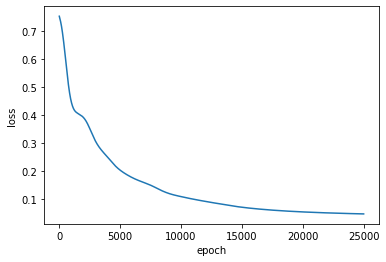

In [25]:
# Plot loss vs epoch
plt.plot(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

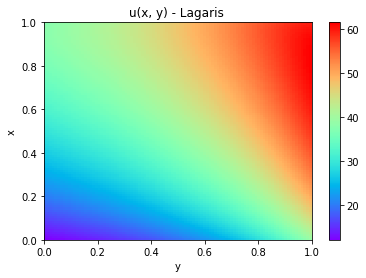

In [28]:
## Plot 
n, m = 100, 100
X = np.linspace(0, +1, m)
Y = np.linspace(0, 1, n)

X0, Y0 = np.meshgrid(X, Y)
X1 = X0.reshape([n*m, 1])
Y1 = Y0.reshape([n*m, 1])

X = tf.convert_to_tensor(X1)
Y = tf.convert_to_tensor(Y1)

S1 = u(X , Y)
S = S1.numpy().reshape(m, n)

plt.pcolormesh( X0, Y0 , S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y) - Lagaris ")
plt.ylabel("x")
plt.xlabel("y")
plt.show()

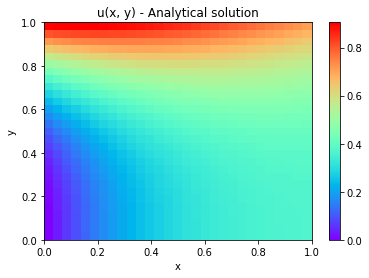

In [29]:
## Plotting Analytical solution
def ff(x, y):
    return np.exp(-x)*(x + np.power(y , 3))

x = np.linspace(0, 1, 30)
y = np.linspace(0, 1, 30)

X, Y = np.meshgrid(x, y)
Z = ff(X, Y)

plt.pcolormesh(X, Y, Z, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y) - Analytical solution")
plt.ylabel("y")
plt.xlabel("x")
plt.show()

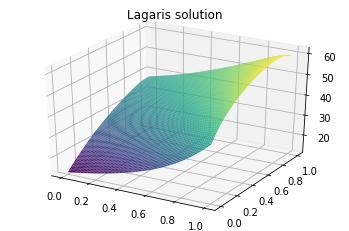

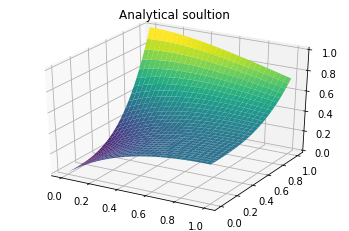

In [30]:
## Lagaris Solution

ax = plt.axes(projection='3d')
ax.plot_surface(X0, Y0, S, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Lagaris solution');
plt.show()

## Analytical solution 

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Analytical soultion');

### b) Repeat the same case with the PINN approach for boundary conditions. What (if any) differences do you observe in your results?

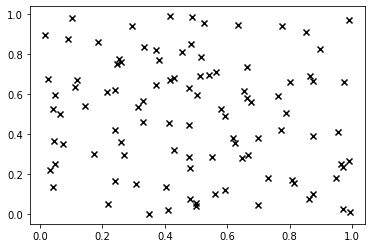

In [31]:
## Creating data 
# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)

# change names
x_c = np.expand_dims(data[:, 0], axis=1)
y_c = np.expand_dims(data[:, 1], axis=1)

plt.scatter(x_c[0:100] , y_c[0:100] , marker="x", c="k")

In [32]:
## Generating data

# number of boundary and initial data points
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1)

# temporal data points
y_d = engine.random(n=number_of_ic_points)
temp1 = np.zeros([number_of_bc1_points, 1]) # for IC ; y = 0
temp2 = np.ones([number_of_bc2_points, 1]) # for IC ; y = 1
y_d = np.append( temp1 , y_d, axis=0)
y_d = np.append( temp2, y_d, axis=0)
# spatial data points
x_d = engine.random(n=number_of_ic_points)
# x_d = 2 * (x_d - 0.5)
temp1 = np.zeros([number_of_bc1_points, 1]) # for BC1 ; x = 0
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

In [33]:
pd.DataFrame({"x_d": x_d.reshape((100,)), "y_d": y_d.reshape((100,))})

,x_d,y_d
0,0.975595,1.000000
1,0.352376,1.000000
2,0.792587,1.000000
3,0.832615,1.000000
4,0.229513,1.000000
...,...,...
95,1.000000,0.987429
96,1.000000,0.183909
97,1.000000,0.408469
98,1.000000,0.231338


In [34]:
t_d.shape , x_d.shape

(TensorShape([100, 1]), (100, 1))

Text(0.5, 1.0, 'Data points (BCs & IC)')

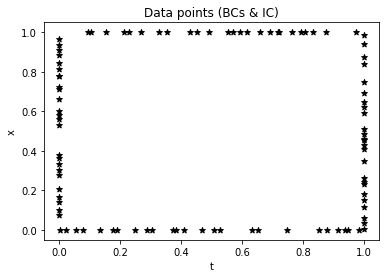

In [35]:
# view randomly sampled boundary and initial points
plt.scatter(x_d, y_d, marker="*", c="k")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

In [36]:
# output values for data points (boundary and initial)
z_d = np.zeros(x_d.shape)

# Ψ(0, y) = y3 , Ψ(1, y) = (1 + y3)e−1 and Ψ(x, 0) = xe−x, Ψ(x, 1) = e−x(x + 1).
# for initial condition:  y =1 
z_d[ : 25] = np.exp(-x_d[:25])*(x_d[:25] + 1)

# Boundary condition : y = 0
z_d[25 : 50] = x_d[25: 50]*np.exp(-x_d[25 : 50])

# Boundary condition : x = 0
z_d[ 50 : 75] = np.power(y_d[ 50 : 75] , 3)

# Boundary condition : x = 1
z_d[75:100] = (1 + np.power(y_d[ 75 : 100] , 3))*np.exp(-1)

In [37]:
# convert all data and collocation points to tf.Tensor
x_d, y_d, z_d, x_c, y_c = map(tf.convert_to_tensor, [x_d, y_d, z_d, x_c, y_c])

In [38]:
x_d.dtype , y_d.dtype , z_d.dtype , x_c.dtype , y_c.dtype

(tf.float64, tf.float64, tf.float64, tf.float64, tf.float64)

In [39]:
## Model design

neuron_per_layer = 20

# activation function for all hidden layers
actfn = "tanh"

# input layer
input_layer = tf.keras.layers.Input(shape=(2,))

# hidden layer: also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)
hidden6 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden5)
hidden7 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden6)
hidden8 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden7)

# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden8)

model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_12 (Dense)            (None, 20)                60        
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 20)                420       
                                                                 
 dense_15 (Dense)            (None, 20)                420       
                                                                 
 dense_16 (Dense)            (None, 20)                420       
                                                                 
 dense_17 (Dense)            (None, 20)                420 

In [40]:
# MSE loss function: This loss function is used for data points
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

# u(t, x) just makes working with model easier and the whole code looks more like its mathematical backend
@tf.function
def u(t, x):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model(tf.concat([t, x], axis=1)) # note the axis ; `column`
    return u

@tf.function
def f(x, y):
    u0 = u(x, y)
    u_y = tf.gradients(u0, y)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x,x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    u_yx = tf.gradients(u_y,x)[0]
    F = u_xx + u_yy + 2*u_yx - tf.exp(-x)*(x - 2 + tf.math.pow(y, 3) + 6*y)
    return tf.reduce_mean(tf.square(F))

In [41]:
epochs = 1000
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

# training loop: a while-based training loop is more beneficial- updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_ = u( x_d , y_d)
        y_ = tf.cast(y_, tf.float64)
        
        # physics-informed loss for collocation points
        L1 = f(x_c , y_c)
        
        # MSE loss for data points # boundary loss
        L2 = mse(z_d, y_)
        loss = L1 + L2
    
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"epoch - {epoch:4} /{epochs} : {loss.numpy():.3f}")
    
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

epoch -    0 /1000 : 6.952
epoch -   10 /1000 : 2.714
epoch -   20 /1000 : 2.308
epoch -   30 /1000 : 1.897
epoch -   40 /1000 : 1.577
epoch -   50 /1000 : 1.220
epoch -   60 /1000 : 0.849
epoch -   70 /1000 : 0.729
epoch -   80 /1000 : 0.625
epoch -   90 /1000 : 0.535
epoch -  100 /1000 : 0.448
epoch -  110 /1000 : 0.375
epoch -  120 /1000 : 0.311
epoch -  130 /1000 : 0.255
epoch -  140 /1000 : 0.205
epoch -  150 /1000 : 0.163
epoch -  160 /1000 : 0.129
epoch -  170 /1000 : 0.103
epoch -  180 /1000 : 0.084
epoch -  190 /1000 : 0.070
epoch -  200 /1000 : 0.059
epoch -  210 /1000 : 0.050
epoch -  220 /1000 : 0.044
epoch -  230 /1000 : 0.038
epoch -  240 /1000 : 0.034
epoch -  250 /1000 : 0.030
epoch -  260 /1000 : 0.027
epoch -  270 /1000 : 0.025
epoch -  280 /1000 : 0.023
epoch -  290 /1000 : 0.021
epoch -  300 /1000 : 0.020
epoch -  310 /1000 : 0.019
epoch -  320 /1000 : 0.018
epoch -  330 /1000 : 0.017
epoch -  340 /1000 : 0.016
epoch -  350 /1000 : 0.015
epoch -  360 /1000 : 0.014
e

Text(0.5, 0, 'epoch')

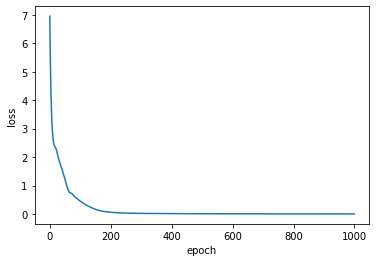

In [42]:
## Plot loss vs epoch
plt.plot(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

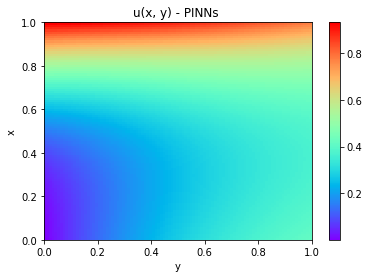

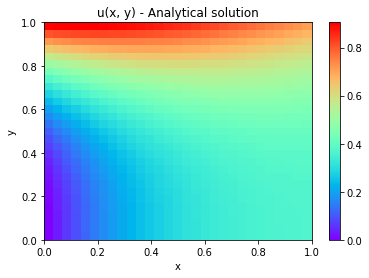

In [44]:
## Plot 
n, m = 100, 100
X = np.linspace(0, +1, m)
Y = np.linspace(0, 1, n)
X0, Y0 = np.meshgrid(X, Y)
X1 = X0.reshape([n*m, 1])
Y1 = Y0.reshape([n*m, 1])
X = tf.convert_to_tensor(X1)
Y = tf.convert_to_tensor(Y1)
S1 = u(X , Y)
S = S1.numpy().reshape(m, n)
plt.pcolormesh( X0, Y0 , S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y) - PINNs ")
plt.ylabel("x")
plt.xlabel("y")
plt.show()



## Plotting Analytical solution
def ff(x, y):
    return np.exp(-x)*(x + np.power(y , 3))

x = np.linspace(0, 1, 30)
y = np.linspace(0, 1, 30)

X, Y = np.meshgrid(x, y)
Z = ff(X, Y)

plt.pcolormesh(X, Y, Z, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y) - Analytical solution")
plt.ylabel("y")
plt.xlabel("x")
plt.show()

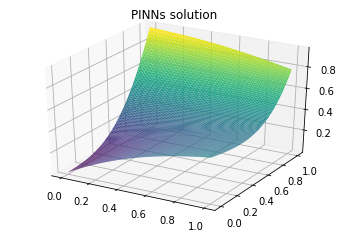

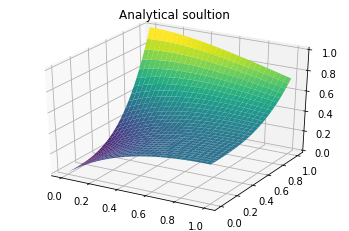

In [45]:
## PINN Solutions

ax = plt.axes(projection='3d')
ax.plot_surface(X0, Y0, S, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('PINNs solution');
plt.show()

## Analytical solution 

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Analytical soultion');

### In Lagaris method we are not getting exact solution equal to analytical , becuase our loss function is not convering to 0 , this is be becuase we are using only one layer with 10 neurons, while PINNs are able to exact solution similar to analytics , this is becuase we are using full connect deep neural network with 8 layers and 20 neurons in each layer.